# Debt Market Model

<center><img src="diagrams/debt_dynamics.png" alt="Debt dynamics" width="60%"/>

$$
\Delta{t} = t_{k+1} - t_{k}\\
{Q}_{k+1} = {Q}_k + v_1 - v_2 - v_3\\
{D_1}_{k+1} = {D_1}_k + u_1 - u_2 - u_3\\
w_3 = u_3 \cdot \frac{w_2}{u_2}\\
w_1 = [(1+\beta_k)^{\Delta{t}}-1]({D_1}_k+{D_2}_k)\\
{D_2}_{k+1} = {D_2}_k + w_1 - w_2 - w_3\\
{R}_{k+1} = {R}_k + w_2\\
$$

## First phase
* Debt market state -> ETH price changes (exogenous) -> exogenous u,v -> endogenous w -> mutates system state

## Second phase
* APT model, arbitragers act -> u,v activity (to remove diversifiable risk) -> results in change to both debt market and secondary market -> stability controller updates redemption rate and price

## Resources
* https://community-development.makerdao.com/en/learn/vaults/liquidation/

In [1]:
from shared import *

In [2]:
# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

In [3]:
# import radCAD as rc
# from radCAD import Model, Simulation

In [4]:
import scipy.stats as sts
import numpy as np
import datetime as dt

In [5]:
def resolve_time_passed(params, substep, state_history, state):
    seconds = params['seconds_passed'](state['timestep'])
    
    return {'seconds_passed': seconds}

def store_timedelta(params, substep, state_history, state, policy_input):

    value = policy_input['seconds_passed']
    key = 'timedelta'

    return key,value

def update_timestamp(params, substep, state_history, state, policy_input):

    seconds = policy_input['seconds_passed']
    value = state['timestamp'] + dt.timedelta(seconds = int(seconds))
    key = 'timestamp'

    return key,value

def update_cumulative_time(params, substep, state_history, state, policy_input):
    seconds = policy_input['seconds_passed']
    
    return 'cumulative_time', state['cumulative_time'] + seconds

In [6]:
def process_raw_results(raw_results):
    df = pd.DataFrame(raw_results)
    max_substep = max(df.substep)
    is_droppable = (df.substep != max_substep)
    is_droppable &= (df.substep != 0)
    df = df.loc[~is_droppable]
    return df

In [7]:
def p_resolve_eth_price(params, substep, state_history, state):
    base_var = params['eth_market_std']
    variance = float(base_var * state['timedelta'] / 3600.0)
    random_state = params['random_state']
    delta_eth_price = sts.norm.rvs(loc=0, scale=variance, random_state=random_state)
    
    return {'delta_eth_price': delta_eth_price}

def s_update_eth_price(params, substep, state_history, state, policy_input):
    #eth_price = state['eth_price']
    #delta_eth_price = policy_input['delta_eth_price']
    eth_price = params['eth_price'](state['timestep'])
    delta_eth_price = 0
    
    return 'eth_price', eth_price + delta_eth_price

def s_update_redemption_price(params, substep, state_history, state, policy_input):
    eth_collateral = state['eth_collateral']
    eth_price = state['eth_price']
    collateral_value = eth_collateral * eth_price
    
    principal_debt = state['principal_debt']
    redemption_price = collateral_value / principal_debt
    
    return 'redemption_price', redemption_price

In [8]:
def p_open_cdps(params, substep, state_history, state):
#     base_var = 0.2
#     variance = float(base_var * state['timedelta'] / 3600.0)
#     random_state = params['random_state']
#     rvs = sts.norm.rvs(loc=0, scale=variance, random_state=random_state)
#     v1 = max(rvs, 0) # total Eth value of new CDP
    
#     # cdps = state['cdps']

#     liquidation_ratio = params['liquidation_ratio']
#     collateral_value = v1 * state['eth_price']
#     redemption_price = state['redemption_price']
#     u1 = collateral_value / (redemption_price * liquidation_ratio)
    
#     cumulative_time = state['cumulative_time']
#     # Hourly activity
#     if cumulative_time % 3600 == 0:
#         return {'delta_v1': v1, 'delta_u1': u1}
#     else:
#         return {'delta_v1': 0, 'delta_u1': 0}

    delta_v1 = params['delta_v1'](state['timestep'])
    delta_u1 = params['delta_u1'](state['timestep'])
    
    return {'delta_v1': delta_v1, 'delta_u1': delta_u1}

def p_close_cdps(params, substep, state_history, state):    
    cdps = state['cdps']
    average_debt_age = params['average_debt_age']
    cumulative_time = state['cumulative_time']
    
    closed_cdps = cdps.query(f'{cumulative_time} - time >= {average_debt_age}')
    delta_v2 = closed_cdps['locked'].sum()
    delta_u2 = closed_cdps['drawn'].sum()
    
    return {'closed_cdps': closed_cdps, 'delta_v2': delta_v2, 'delta_u2': delta_u2}

def p_liquidate_cdps(params, substep, state_history, state):
    eth_price = state['eth_price']
    redemption_price = state['redemption_price']
    liquidation_penalty = params['liquidation_penalty']
    
    cdps = state['cdps']
    liquidated_cdps = cdps.query('locked > 0').query(f'locked * {eth_price} * {liquidation_ratio} < drawn * {redemption_price}')
    
    if len(liquidated_cdps.index) > 0:
        delta_u3 = liquidated_cdps['drawn'].sum()
        delta_v3 = (delta_u3 * redemption_price * (1 + liquidation_penalty)) / eth_price
        eth_locked = liquidated_cdps['locked'].sum()
        delta_v3 = max(delta_v3, eth_locked)
        #assert delta_v3 < eth_locked, f'{delta_v3} !< {eth_locked}'
        # Assume remaining collateral freed
        delta_v2 = max(eth_locked - delta_v3, 0)
        #assert delta_v2 > 0, f'{delta_v2} !> {0}'
    else:
        delta_v3 = 0
        delta_u3 = 0
        delta_v2 = 0
    
    return {'liquidated_cdps': liquidated_cdps, 'delta_v3': delta_v3, 'delta_u3': delta_u3, 'delta_v2': delta_v2}

def s_resolve_cdps(params, substep, state_history, state, policy_input):
    delta_v1 = policy_input['delta_v1']
    delta_u1 = policy_input['delta_u1']
    cdps = state['cdps']
    
    liquidated_cdps = policy_input['liquidated_cdps']
    closed_cdps = policy_input['closed_cdps']
    drop_index = liquidated_cdps.index.union(closed_cdps.index)
    try:
        cdps = cdps.drop(drop_index)
    except KeyError:
        print('Failed to drop CDPs')
        raise
        
    if delta_v1 > 0:
        cumulative_time = state['cumulative_time']
        cdps = cdps.append({
            'time': cumulative_time,
            'locked': delta_v1,
            'drawn': delta_u1,
            'wiped': 0.0,
            'freed': 0.0,
            'dripped': 0.0
        }, ignore_index=True)
    
    return 'cdps', cdps

def s_update_eth_collateral(params, substep, state_history, state, policy_input):
    eth_locked = state['eth_locked']
    eth_freed = state['eth_freed']
    eth_bitten = state['eth_bitten']
    
    return 'eth_collateral', eth_locked - eth_freed - eth_bitten

def s_update_principal_debt(params, substep, state_history, state, policy_input):
    rai_drawn = state['rai_drawn']
    rai_wiped = state['rai_wiped']
    rai_bitten = state['rai_bitten']
    
    return 'principal_debt', rai_drawn - rai_wiped - rai_bitten

def s_update_eth_locked(params, substep, state_history, state, policy_input):
    eth_locked = state['eth_locked']
    delta_v1 = policy_input['delta_v1']
    
    return 'eth_locked', eth_locked + delta_v1

def s_update_eth_freed(params, substep, state_history, state, policy_input):
    eth_freed = state['eth_freed']
    delta_v2 = policy_input['delta_v2']
    
    return 'eth_freed', eth_freed + delta_v2

def s_update_eth_bitten(params, substep, state_history, state, policy_input):
    eth_bitten = state['eth_bitten']
    delta_v3 = policy_input['delta_v3']
    
    return 'eth_bitten', eth_bitten + delta_v3

def s_update_rai_drawn(params, substep, state_history, state, policy_input):
    rai_drawn = state['rai_drawn']
    delta_u1 = policy_input['delta_u1']
    
    return 'rai_drawn', rai_drawn + delta_u1

def s_update_rai_wiped(params, substep, state_history, state, policy_input):
    rai_wiped = state['rai_wiped']
    delta_u2 = policy_input['delta_u2']
    
    return 'rai_wiped', rai_wiped + delta_u2

def s_update_rai_bitten(params, substep, state_history, state, policy_input):
    rai_bitten = state['rai_bitten']
    delta_v3 = policy_input['delta_v3']
    
    return 'rai_bitten', rai_bitten + delta_v3
    
def s_update_accrued_interest(params, substep, state_history, state, policy_input):
    previous_accrued_interest = state['accrued_interest']
    principal_debt = state['principal_debt']
    
    stability_fee = state['stability_fee']
    timedelta = state['timedelta']
    
    accrued_interest = ((1 + stability_fee)**timedelta - 1) * (principal_debt + previous_accrued_interest)
    return 'accrued_interest', previous_accrued_interest + accrued_interest

In [9]:
debt_market_df = pd.read_csv('market_model/data/debt_market_df.csv', index_col='date', parse_dates=True)

In [10]:
debt_market_df.insert(0, 'seconds_passed', 24 * 3600)

debt_market_df.head()

seconds_passed    rho_star   beta         p             Q  \
date                                                                    
2017-12-18           86400  736.004090  0.005  1.017605   2425.662000   
2017-12-19           86400  832.236972  0.005  1.003376   6240.431314   
2017-12-20           86400  810.287507  0.005  1.012972  14183.070621   
2017-12-21           86400  837.231080  0.005  1.025738  15644.732690   
2017-12-22           86400  689.014990  0.005  0.972228  18830.844186   

                    v_1    v_2 + v_3           u_1      u_2 + u_3  \
date                                                                
2017-12-18  2526.662000   101.000000  5.953420e+05      45.943840   
2017-12-19  3821.320309     6.550995  1.379832e+06   35394.482980   
2017-12-20  8066.895210   124.255903  2.676383e+06  502251.750000   
2017-12-21  1471.742069    10.080000  8.053550e+05   49782.711992   
2017-12-22  5316.960481  2130.848985  3.145512e+05  747453.127687   

                      u_2  ...          u_3       w_3  w_2 + w_3  \
date                       ...                                     
2017-12-18      10.000000  ...     35.94384  0.000023   0.000029   
2017-12-19   35367.482980  ...     27.00000  0.000348   0.456233   
2017-12-20  501412.750000  ...    839.00000  0.000299   0.179179   
2017-12-21   49782.711992  ...      0.00000  0.000000   1.158909   
2017-12-22  723915.309687  ...  23537.81800  0.642374  20.398842   

                     D_1         D_2        w_1             D        C_star  \
date                                                                          
2017-12-18  5.952961e+05    0.000000   0.000000  5.952961e+05  1.785297e+06   
2017-12-19  1.939733e+06   26.049429  26.505662  1.939759e+06  5.193518e+06   
2017-12-20  4.113865e+06   82.084882  56.214632  4.113947e+06  1.149236e+07   
2017-12-21  4.869437e+06  147.465956  66.539983  4.869584e+06  1.309826e+07   
2017-12-22  4.436535e+06  187.692564  60.625449  4.436723e+06  1.297473e+07   

            p_star  p_ema_10  
date                          
2017-12-18       1  1.008573  
2017-12-19       1  1.008573  
2017-12-20       1  1.008573  
2017-12-21       1  1.008573  
2017-12-22       1  1.008573  

[5 rows x 21 columns]

In [11]:
eth_collateral = 100.0
eth_price = debt_market_df['rho_star'].iloc[0] #386.71

liquidation_ratio = 1.5 # 150%
collateral_value = eth_collateral * eth_price
redemption_price = 2.0
principal_debt = collateral_value / (redemption_price * liquidation_ratio)

print(f'''
{principal_debt}
{eth_collateral}
''')


24533.469675925935
100.0



In [12]:
import pandas as pd

cdps = pd.DataFrame()
cdps = cdps.append({
    'time': 0,
    'locked': eth_collateral,
    'drawn': principal_debt,
    'wiped': 0.0,
    'freed': 0.0,
    'dripped': 0.0
}, ignore_index=True)
cdps

drawn  dripped  freed  locked  time  wiped
0  24533.469676      0.0    0.0   100.0   0.0    0.0

In [13]:
initial_state = {
    'timedelta': 0, # seconds
    'cumulative_time': 0, # seconds
    'timestamp': dt.datetime.strptime('12/18/17', '%m/%d/%y'), #datetime
    'cdps': cdps,
    # Loaded from exogenous parameter
    'eth_price': eth_price, # dollars
    # v
    'eth_collateral': eth_collateral, # Q
    'eth_locked': eth_collateral, # v1
    'eth_freed': 0, # v2
    'eth_bitten': 0, # v3 "liquidated"
    # u
    'principal_debt': principal_debt, # D1
    'rai_drawn': principal_debt, # u1 "minted"
    'rai_wiped': 0, # u2 "burned" in repayment
    'rai_bitten': 0, # "burned" in liquidation
    # w
    'accrued_interest': 0, # D2
    #'system_revenue': 0, # R
    'stability_fee': 0.015 / (30 * 24 * 3600), # per second interest rate (1.5% per month)
    #'interest_wiped': 0, # w2, interest repaid - in practice acrues to MKR holders, because interest is actually acrued by burning MKR
    #'interest_bitten': 0, # w3
    'redemption_price': redemption_price, # dollars
}

parameters = {
    'eth_market_std': [1],
    'random_state': [np.random.RandomState(seed=0)],
    'liquidation_ratio': [liquidation_ratio], # %
    'liquidation_penalty': [0.13], # 13%
    # Average CDP duration == 3 months: https://www.placeholder.vc/blog/2019/3/1/maker-network-report
    'average_debt_age': [3 * (30 * 24 * 3600)], # delta t (seconds)
    'eth_price': [lambda timestep, df=debt_market_df: df.iloc[timestep].rho_star],
    'delta_v1': [lambda timestep, df=debt_market_df: df.iloc[timestep].v_1],
    'delta_u1': [lambda timestep, df=debt_market_df: df.iloc[timestep].u_1],
    'seconds_passed': [lambda timestep, df=debt_market_df: df.iloc[timestep].seconds_passed]
}

partial_state_update_blocks = [
    {
        'details': '''
            This block observes (or samples from data) the amount of time passed between events
        ''',
        'policies': {
            'time_process': resolve_time_passed
        },
        'variables': {
            'timedelta': store_timedelta,
            'timestamp': update_timestamp,
            'cumulative_time': update_cumulative_time
        }
    },
    {
        'details': '''
            Update debt market state
        ''',
        'policies': {},
        'variables': {
            'eth_collateral': s_update_eth_collateral,
            'principal_debt': s_update_principal_debt,
            'accrued_interest': s_update_accrued_interest
        }
    },
    {
        'policies': {},
        'variables': {
            'redemption_price': s_update_redemption_price
        }
    },
    {
        'details': '''
            Exogenous ETH price process
        ''',
        'policies': {
            'exogenous_eth_process': p_resolve_eth_price,
        },
        'variables': {
            'eth_price': s_update_eth_price
        }
    },
    {
        'details': '''
            Exogenous u,v activity
        ''',
        'policies': {
            'open_cdps': p_open_cdps,
            'close_cdps': p_close_cdps,
            'liquidate_cdps': p_liquidate_cdps
        },
        'variables': {
            'eth_locked': s_update_eth_locked,
            'eth_freed': s_update_eth_freed,
            'eth_bitten': s_update_eth_bitten,
            'rai_drawn': s_update_rai_drawn,
            'rai_wiped': s_update_rai_wiped,
            'rai_bitten': s_update_rai_bitten,
            'cdps': s_resolve_cdps,
        }
    },
    {
        'details': '''
            Endogenous w activity
        ''',
        'policies': {},
        'variables': {
        }
    }
]

In [14]:
SIMULATION_TIMESTEPS = 600
MONTE_CARLO_RUNS = 1

In [15]:
# model = Model(initial_state=initial_state, psubs=partial_state_update_blocks, params=parameters)
# simulation = Simulation(model=model, timesteps=SIMULATION_TIMESTEPS, runs=MONTE_CARLO_RUNS)

# import time
# start = time.time()
# raw_result = rc.run([simulation])
# end = time.time()
# print(end - start)

# data = process_raw_results(raw_result)

In [16]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

sim_config = config_sim({
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
    'M': parameters
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (600, 9, 1, 16)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 5.66s


In [17]:
simulation_result = pd.DataFrame(raw_result)

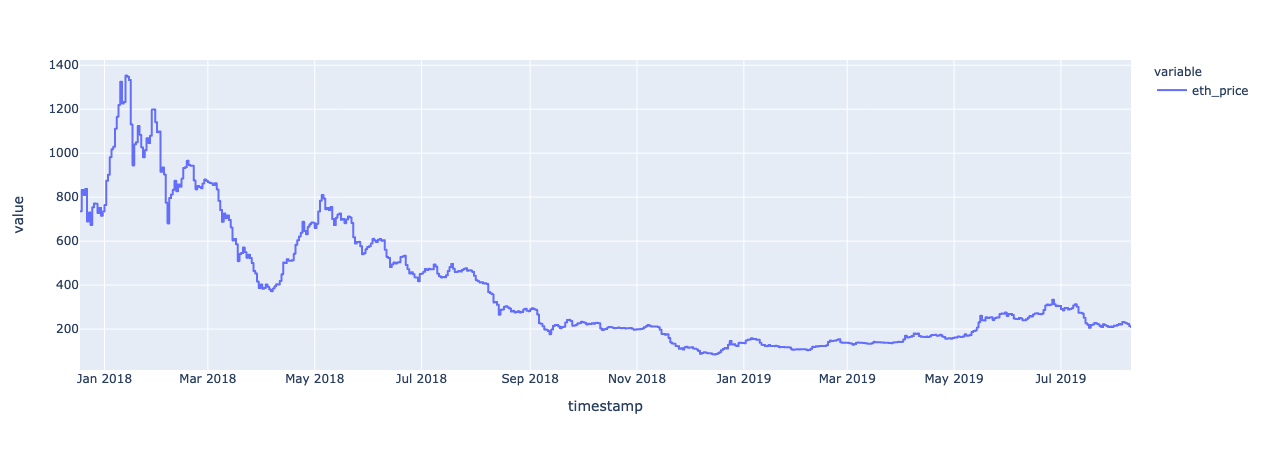

In [18]:
simulation_result.plot(x='timestamp', y=['eth_price'])

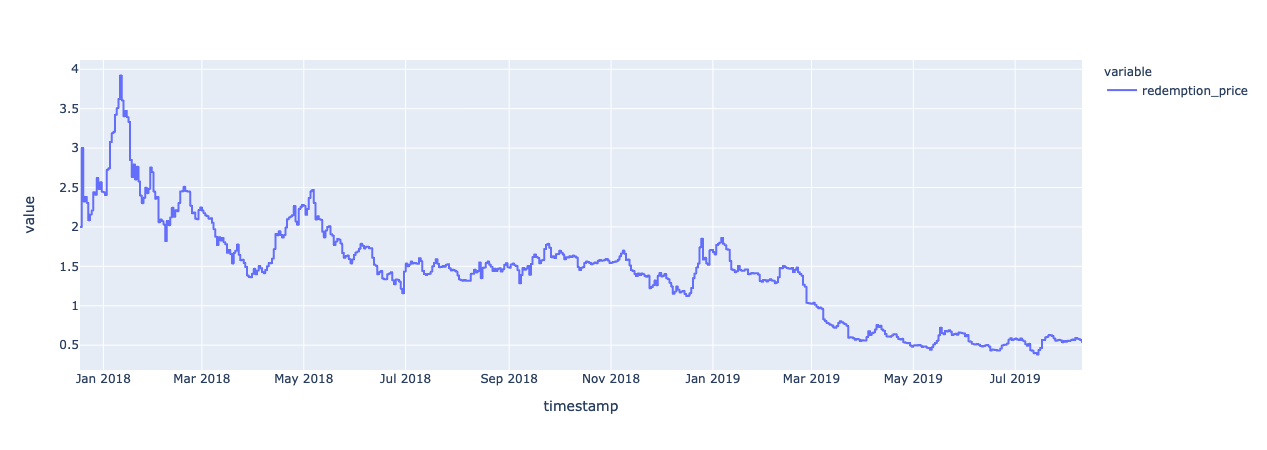

In [19]:
simulation_result.plot(x='timestamp', y=['redemption_price'])

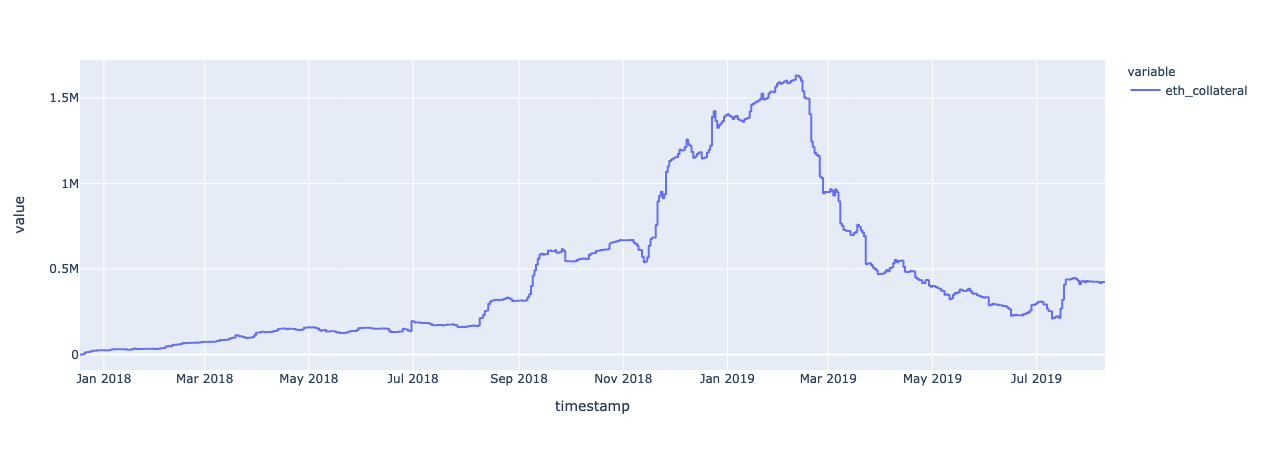

In [20]:
simulation_result.plot(x='timestamp', y=['eth_collateral'])

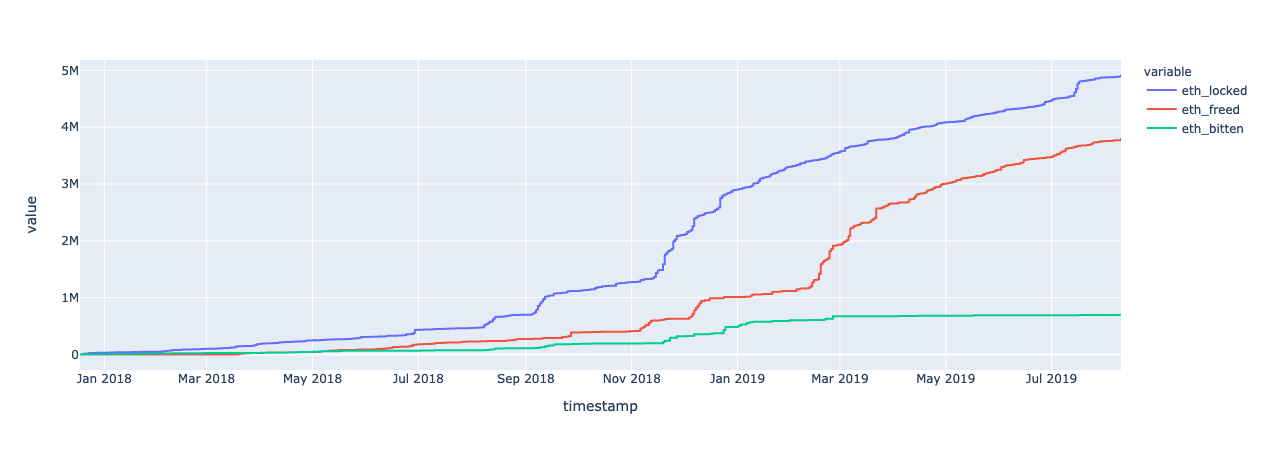

In [21]:
simulation_result.plot(x='timestamp', y=['eth_locked', 'eth_freed', 'eth_bitten'])

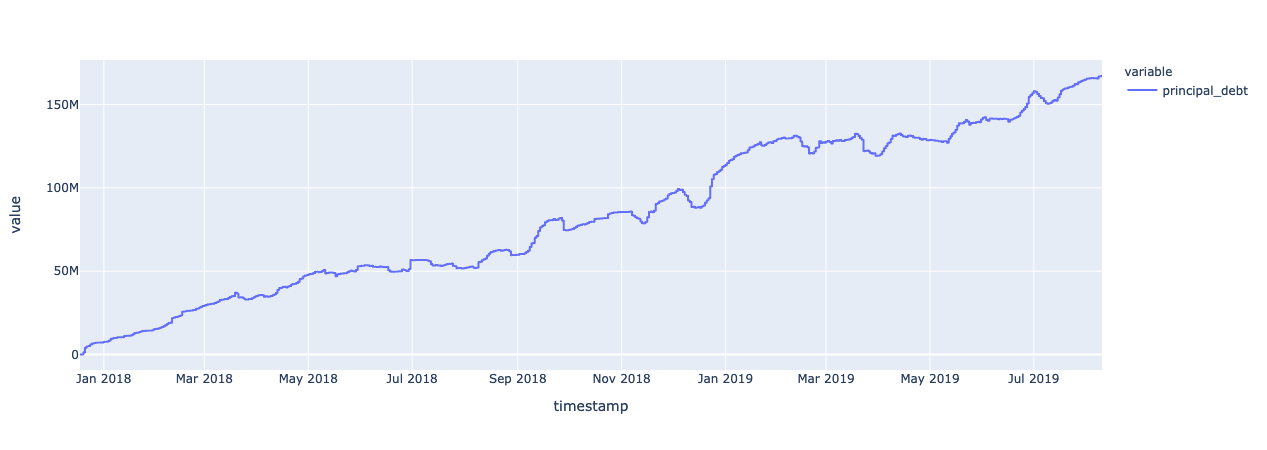

In [22]:
simulation_result.plot(x='timestamp', y=['principal_debt'])

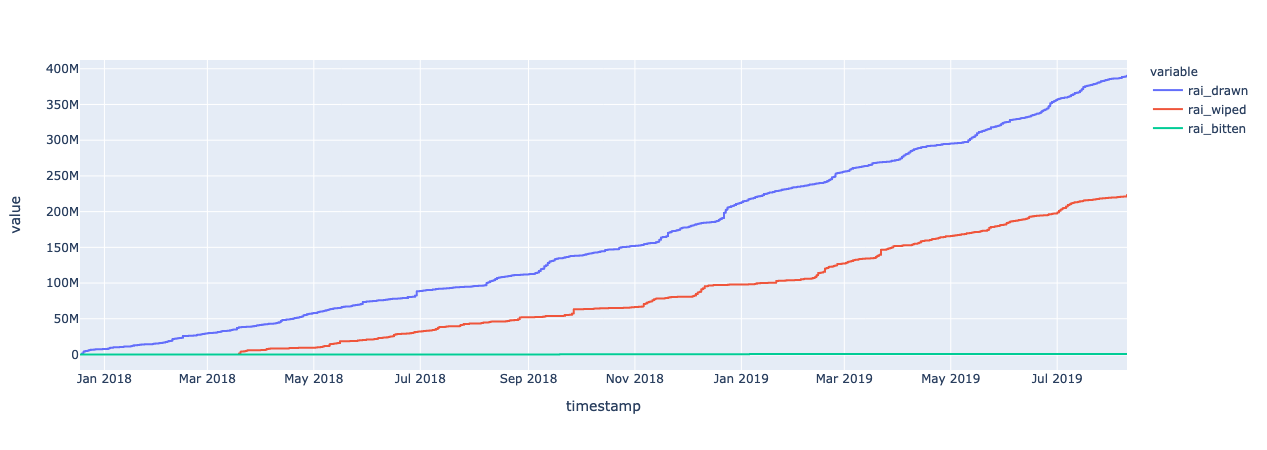

In [23]:
simulation_result.plot(x='timestamp', y=['rai_drawn', 'rai_wiped', 'rai_bitten'])

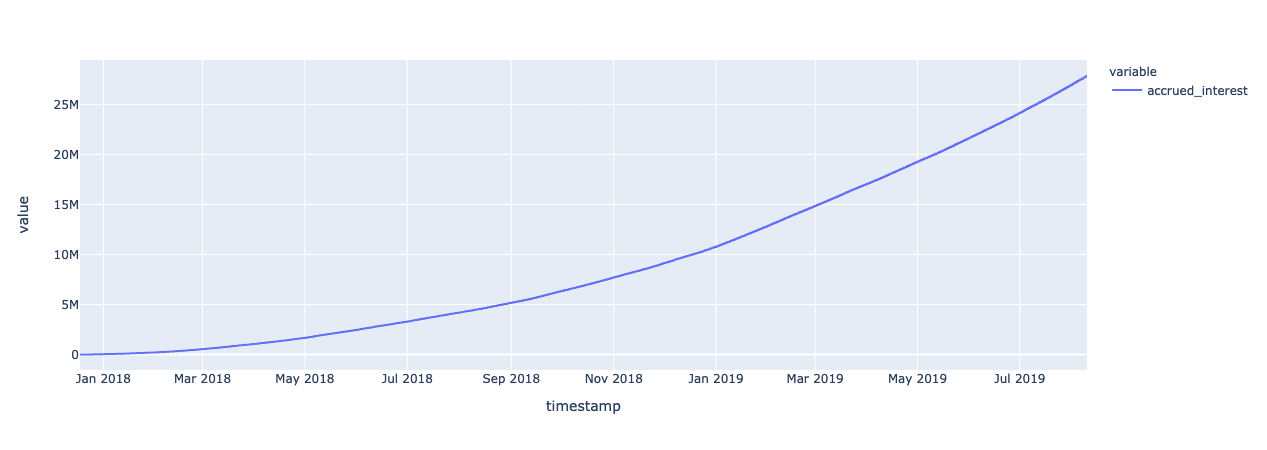

In [24]:
simulation_result.plot(x='timestamp', y=['accrued_interest'])

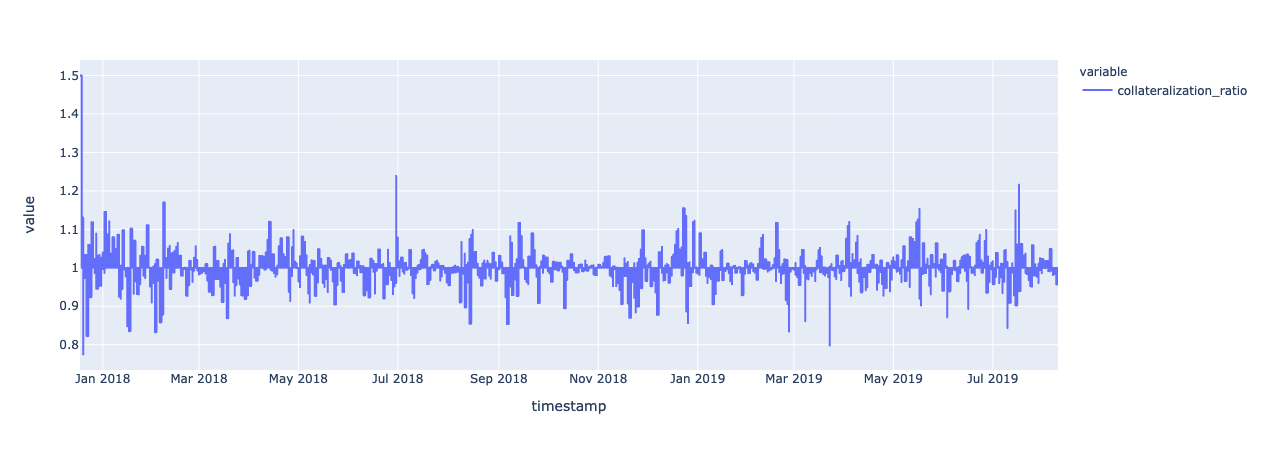

In [25]:
simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.redemption_price)
simulation_result.plot(x='timestamp', y=['collateralization_ratio'])